### This is a synthetic parameter estimation experiment of the L63 model, using Global Bayesian Optimization with Expected Improvement.
* The dimension of the parameter space is 3.
* The initial condition is known.
* There is no additive noise.

In [1]:
import sys
sys.path.insert(0, '/Users/lunderman/Documents/GitHub/LMP19')
import LMP19
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,WhiteKernel

In [2]:
nSteps = 100

L63 = LMP19.Models.L63()
true_theta=[10,28,8/3]
res = L63.get_data(theta=true_theta,nSteps=nSteps,dt=0.01)
L63.traj = res

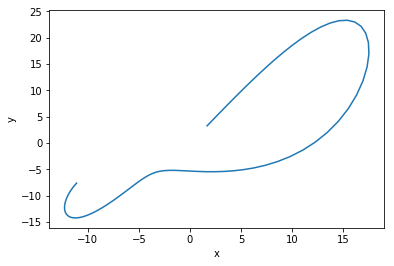

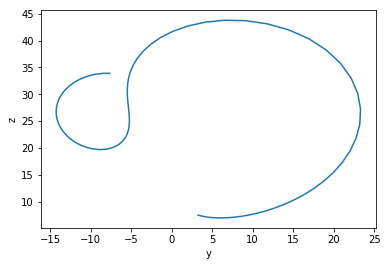

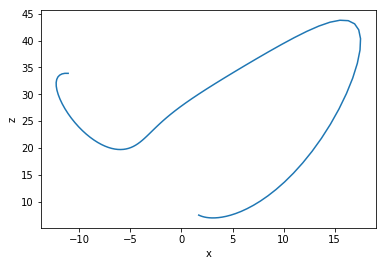

In [3]:
plt.plot(res[0],res[1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.plot(res[1],res[2])
plt.xlabel('y')
plt.ylabel('z')
plt.show()
plt.plot(res[0],res[2])
plt.xlabel('x')
plt.ylabel('z')
plt.show()

In [4]:
err = 3
lb , ub = [10-err,28-err,8/3-err],[10+err,28+err,8/3+err]
bounds = np.array([lb,ub]).T

In [5]:
def J(theta):
    _res = L63.get_data(theta=theta,x0=L63.traj[:,0],nSteps=nSteps,dt=0.01)
    return(-np.linalg.norm(_res.ravel()-L63.traj.ravel()))

In [6]:
nPts = 50
X = np.random.uniform(lb,ub,(nPts,3))
y = np.zeros((nPts,1))
for kk in range(nPts):
    y[kk,0]= J(X[kk,:])

In [7]:
GBO = LMP19.GBO(J,3,X,y,bounds)

kernel = 1.0**2*RBF(np.max(np.diag(np.cov(X.T))))+WhiteKernel(0.5*np.std(y),noise_level_bounds='fixed')
GP = GPR(kernel = kernel,normalize_y=False,n_restarts_optimizer=50).fit(X,y)

In [8]:
nIter = 100
GBO.GP = GP
for kk in range(nIter):
    kernel = 1.0**2*RBF(np.max(np.diag(np.cov(GBO.X.T))))+WhiteKernel(0.5*np.std(GBO.y),noise_level_bounds='fixed')
    GBO.GP = GPR(kernel = kernel,normalize_y=False,n_restarts_optimizer=50).fit(X,y)
    GBO.Expected_Improvement()

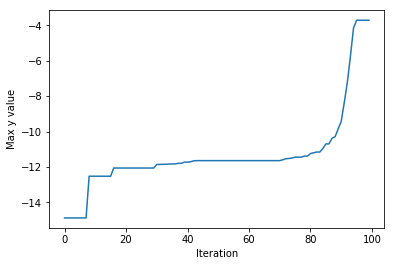

In [9]:
plt.plot(np.arange(nSteps),[np.max(GBO.y[:nPts+kk,0]) for kk in range(nSteps)])
plt.ylabel('Max y value')
plt.xlabel('Iteration')
plt.show()

In [10]:
_res = L63.get_data(theta=GBO.X[np.argmax(GBO.y[:nPts+kk,0]),:],x0=L63.traj[:,0],nSteps=nSteps,dt=0.01)

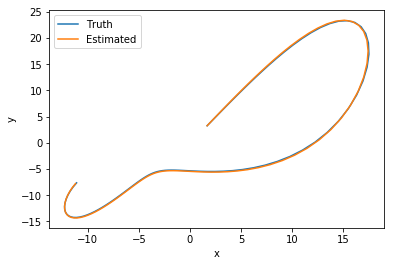

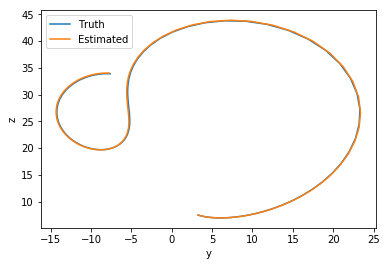

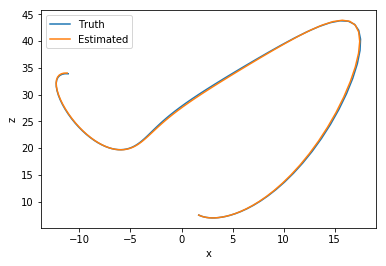

In [11]:
plt.plot(res[0],res[1],label='Truth')
plt.plot(_res[0],_res[1],label='Estimated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
plt.plot(res[1],res[2],label='Truth')
plt.plot(_res[1],_res[2],label='Estimated')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()
plt.show()
plt.plot(res[0],res[2],label='Truth')
plt.plot(_res[0],_res[2],label='Estimated')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.show()

In [12]:
print('Selected model parameters:')
GBO.X[np.argmax(GBO.y[:,0]),:]

Selected model parameters:


array([ 9.68548131, 28.05127642,  2.66526785])

In [13]:
np.argmax(GBO.y[:,0])

144